In [1]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set_style("dark")

In [2]:
import joblib

In [3]:
%cd ..

/workspace/asurion_f22_muby


### Loading Models

In [4]:
xgboost = joblib.load('models/xgb_cls.pkl')

In [5]:
rnd_forest = joblib.load('models/random_forest_classifier_final.pkl')

In [6]:
cat_boost = joblib.load('models/catboost.pkl')

### Hard Voting Ensemble

In [7]:
### Building ensemble model
hard_ensemble = VotingClassifier(estimators = [('xgb', xgboost), ('rnd', rnd_forest),('cat',cat_boost)], voting = 'hard')

#### Model fitting

In [8]:
train = pd.read_csv("fe_data_v2/sale_data/train_sale_encoded.csv")

In [9]:
train = train[(train['zipcode_accepted_prop'].isnull()==False)& (train['zipcode_rejected_offers'].isnull()==False)& 
            (train['zipcode_accepted_offers'].isnull()==False)&(train['zipcode_total_offers'].isnull()==False)]

In [10]:
class_column = "quality_sale"

In [11]:
train = train[['quality_sale', 'lines', 'previous_tech_support_call', 'account_tenure',
               'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
               'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
               'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
               'median_income', 'total_population', 'perc_female', 'perc_under18',
               'perc_over65', 'perc_white', 'perc_black', 'population_density',
               'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
               'zipcode_rejected_offers', 'zipcode_accepted_offers','zipcode_total_offers']]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=class_column), train[class_column],
                                                   test_size=0.3, random_state=42, stratify=train[class_column])

In [13]:
hard_ensemble.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.6733358	total: 174ms	remaining: 1.57s
1:	learn: 0.6567073	total: 284ms	remaining: 1.14s
2:	learn: 0.6452571	total: 388ms	remaining: 905ms
3:	learn: 0.6349407	total: 491ms	remaining: 736ms
4:	learn: 0.6280260	total: 594ms	remaining: 594ms
5:	learn: 0.6222837	total: 698ms	remaining: 465ms
6:	learn: 0.6182256	total: 797ms	remaining: 342ms
7:	learn: 0.6150229	total: 896ms	remaining: 224ms
8:	learn: 0.6096642	total: 1000ms	remaining: 111ms
9:	learn: 0.6071320	total: 1.1s	remaining: 0us


VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('col',
                                               ColumnTransformer(transformers=[('onehot',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['exp',
                                                                                 'product_type',
                                                                                 'pmake',
                                                                                 'technodoption_class',
                                                                                 'hh_income',
                                                                                 'age_class',
                                                                                 'hh_education',
                                   

In [14]:
pred = hard_ensemble.predict(X_test)

In [15]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.56      0.70    234864
           1       0.15      0.75      0.25     24188

    accuracy                           0.58    259052
   macro avg       0.55      0.65      0.48    259052
weighted avg       0.88      0.58      0.66    259052



<AxesSubplot:>

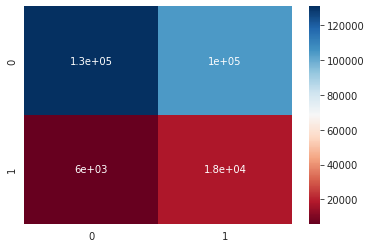

In [16]:
conf = confusion_matrix(y_test, pred)
sns.heatmap(conf, annot = True, cmap = "RdBu")

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
acc = (tp+tn)/(tp +fp +tn +fn)
print("Accuracy Score:", acc)

Accuracy Score: 0.5751239133455831


#### Evaluation on Hold-out data

In [18]:
test = pd.read_csv("fe_data_v2/sale_data/test_sale_encoded.csv")

In [19]:
test = test[(test['zipcode_accepted_prop'].isnull()==False)& (test['zipcode_rejected_offers'].isnull()==False)& 
            (test['zipcode_accepted_offers'].isnull()==False)&(test['zipcode_total_offers'].isnull()==False)]

In [20]:
test = test[['quality_sale', 'lines', 'previous_tech_support_call', 'account_tenure',
               'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
               'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
               'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
               'median_income', 'total_population', 'perc_female', 'perc_under18',
               'perc_over65', 'perc_white', 'perc_black', 'population_density',
               'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
               'zipcode_rejected_offers', 'zipcode_accepted_offers','zipcode_total_offers']]

In [21]:
X_hold_out = test.drop(columns=class_column)
y_hold_out = test[class_column]

In [22]:
pred_hold_out = hard_ensemble.predict(X_hold_out)

In [23]:
print(classification_report(y_hold_out, pred_hold_out))

              precision    recall  f1-score   support

           0       0.94      0.55      0.70    205780
           1       0.10      0.58      0.17     17365

    accuracy                           0.55    223145
   macro avg       0.52      0.56      0.43    223145
weighted avg       0.87      0.55      0.65    223145



<AxesSubplot:>

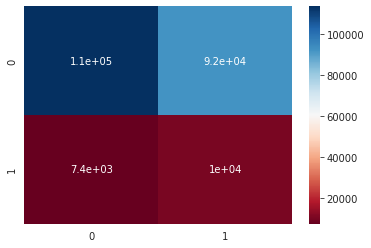

In [24]:
conf = confusion_matrix(y_hold_out, pred_hold_out)
sns.heatmap(conf, annot = True, cmap = "RdBu")

In [25]:
tn, fp, fn, tp = confusion_matrix(y_hold_out, pred_hold_out).ravel()
acc = (tp+tn)/(tp +fp +tn +fn)
print("Accuracy Score:", acc)

Accuracy Score: 0.5537386004615833


### Soft Voting Ensemble 

In [26]:
## Building ensemble model
soft_ensemble = VotingClassifier(estimators = [('xgb', xgboost), ('rnd', rnd_forest),("cat", cat_boost)], voting = 'soft')

#### Model Fitting

In [27]:
soft_ensemble.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.6733358	total: 168ms	remaining: 1.51s
1:	learn: 0.6567073	total: 309ms	remaining: 1.24s
2:	learn: 0.6452571	total: 460ms	remaining: 1.07s
3:	learn: 0.6349407	total: 601ms	remaining: 902ms
4:	learn: 0.6280260	total: 722ms	remaining: 722ms
5:	learn: 0.6222837	total: 846ms	remaining: 564ms
6:	learn: 0.6182256	total: 980ms	remaining: 420ms
7:	learn: 0.6150229	total: 1.11s	remaining: 278ms
8:	learn: 0.6096642	total: 1.27s	remaining: 141ms
9:	learn: 0.6071320	total: 1.38s	remaining: 0us


VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('col',
                                               ColumnTransformer(transformers=[('onehot',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['exp',
                                                                                 'product_type',
                                                                                 'pmake',
                                                                                 'technodoption_class',
                                                                                 'hh_income',
                                                                                 'age_class',
                                                                                 'hh_education',
                                   

In [28]:
pred = soft_ensemble.predict(X_test)

In [29]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.58      0.72    234864
           1       0.15      0.74      0.25     24188

    accuracy                           0.59    259052
   macro avg       0.55      0.66      0.49    259052
weighted avg       0.88      0.59      0.68    259052



<AxesSubplot:>

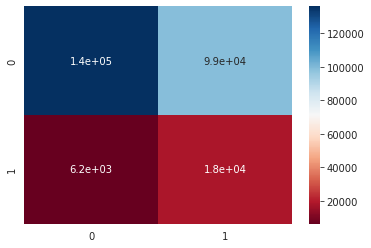

In [30]:
conf = confusion_matrix(y_test, pred)
sns.heatmap(conf, annot = True, cmap = "RdBu")

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
acc = (tp+tn)/(tp +fp +tn +fn)
print("Accuracy Score:", acc)

Accuracy Score: 0.5943903154579003


#### Evaluation on Hold-out data

In [32]:
pred_hold_out = soft_ensemble.predict(X_hold_out)

In [33]:
print(classification_report(y_hold_out, pred_hold_out))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71    205780
           1       0.10      0.57      0.17     17365

    accuracy                           0.57    223145
   macro avg       0.52      0.57      0.44    223145
weighted avg       0.88      0.57      0.67    223145



<AxesSubplot:>

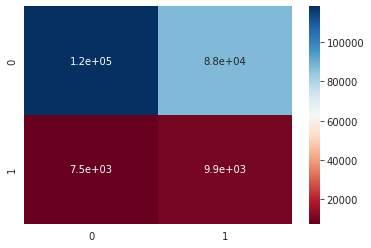

In [34]:
conf = confusion_matrix(y_hold_out, pred_hold_out)
sns.heatmap(conf, annot = True, cmap = "RdBu")

In [35]:
tn, fp, fn, tp = confusion_matrix(y_hold_out, pred_hold_out).ravel()
acc = (tp+tn)/(tp +fp +tn +fn)
print("Accuracy Score:", acc)

Accuracy Score: 0.5743619619529902
